# Merge of catalogs from DJA and SE++

This notebook merges the catalogs from SourceXtractor++ (Sersic and Bulge+Disk models) with the catalogs from the DJA (aperture photometry and photo-z).

In [1]:
import os
import glob
import boto3
s3 = boto3.client('s3')
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo
from astropy.table import Table, hstack
from astropy.stats import sigma_clipped_stats
import astropy.units as u
import dja_sepp

plt.rcParams['xtick.labelsize']='large'
plt.rcParams['ytick.labelsize']='large'
plt.rcParams['axes.labelsize']='x-large'
plt.rcParams['legend.fontsize']='large'
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
# %matplotlib ipympl

First, we load the DJA and SE++ catalogs.

In [2]:
home = "/home/aurelien/DAWN/DJA-SEpp"
field = 'primer-cosmos-west-grizli-v7.0'

In [3]:
# Download DJA catalogs
folder = f"{home}/fields/{field}/catalog/dja"
os.makedirs(folder, exist_ok=True)
cat_dja = dja_sepp.s3.find_files(bucket='grizli-v2', 
                                 path='JwstMosaics/v7', 
                                 regex=f"{field}-fix.photoz.tar.gz")[0]
print(cat_dja)
s3.download_file('grizli-v2', f"JwstMosaics/v7/{cat_dja}", f"{folder}/{cat_dja}")
with tarfile.open(f"{folder}/{cat_dja}") as f:
    fits_file = [name for name in f.getnames() if '.fits' in name]
    for file in fits_file:
        f.extract(file, folder)
os.remove(f"{folder}/{cat_dja}")

primer-cosmos-west-grizli-v7.0-fix.photoz.tar.gz


In [4]:
# Download SE++ catalogs
sersic_folder = f"{home}/fields/{field}/sepp/sersic_rg4"
os.makedirs(sersic_folder, exist_ok=True)
sersic_cat = dja_sepp.s3.find_files(bucket='aurelien-sepp', 
                                    path=f'{field}/sepp/sersic_rg4', 
                                    regex=".+tile-full+_sepp_cat\.fits")[0]
print(sersic_cat)
s3.download_file('aurelien-sepp', f"{field}/sepp/sersic_rg4/{sersic_cat}", f"{sersic_folder}/{sersic_cat}")

BD_folder = f"{home}/fields/{field}/sepp/B+D"
os.makedirs(BD_folder, exist_ok=True)
BD_cat = dja_sepp.s3.find_files(bucket='aurelien-sepp', 
                                path=f'{field}/sepp/B+D', 
                                regex=".+tile-full+_sepp_cat\.fits")[0]
print(BD_cat)
s3.download_file('aurelien-sepp', f"{field}/sepp/B+D/{BD_cat}", f"{BD_folder}/{BD_cat}")

primer-cosmos-west-grizli-v7.0-ir_drc_sci_tile-full_sepp_cat.fits
primer-cosmos-west-grizli-v7.0-ir_drc_sci_tile-full_sepp_cat.fits


In [5]:
with fits.open(glob.glob(f"{home}/fields/{field}/catalog/dja/*fix_phot_apcorr.fits")[0]) as hdul:
    phot_dja = Table(hdul[1].data)
with fits.open(glob.glob(f"{home}/fields/{field}/catalog/dja/*zout.fits")[0]) as hdul:
    phot_z_dja = Table(hdul[1].data)
with fits.open(glob.glob(f"{home}/fields/{field}/sepp/sersic_rg4/*sci_tile-full_sepp_cat.fits")[0]) as hdul:
    phot_sersic = Table(hdul[1].data)
with fits.open(glob.glob(f"{home}/fields/{field}/sepp/B+D/*sci_tile-full_sepp_cat.fits")[0]) as hdul:
    phot_BD = Table(hdul[1].data)

We compare the number of sources in each catalog :
* Complete DJA catalog
* Complete SE++ catalog
* Cutout of the DJA catalog with the same footprint as the SE++ catalog

In [6]:
print(f"Sources in DJA photometry catalog   : {len(phot_dja)}")
print(f"Sources in DJA photo-z catalog      : {len(phot_z_dja)}")
print(f"Sources in Sersic catalog           : {len(phot_sersic)}")
print(f"Sources in B+D catalog              : {len(phot_BD)}")

Sources in DJA photometry catalog   : 59114
Sources in DJA photo-z catalog      : 59114
Sources in Sersic catalog           : 208485
Sources in B+D catalog              : 198605


We do a scatter plot of all the sources to visually see the footprint of the catalogs.

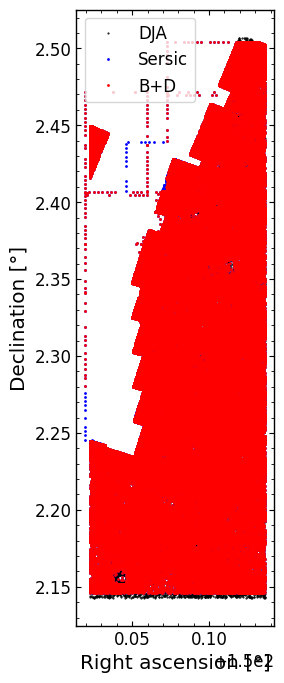

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(phot_dja['ra'], phot_dja['dec'], marker='o', ls='', ms=0.5, c='k', label='DJA')
ax.plot(phot_sersic['world_centroid_alpha'], phot_sersic['world_centroid_delta'], marker='o', ls='', ms=1, c='b', label='Sersic')
ax.plot(phot_BD['world_centroid_alpha'], phot_BD['world_centroid_delta'], marker='o', ls='', ms=1, c='r', label='B+D')
ax.set_xlabel('Right ascension [°]')
ax.set_ylabel('Declination [°]')
# ax.set_xlim(214.88, 214.95)
# ax.set_ylim(52.83, 52.88)
ax.set_aspect('equal')
ax.legend()
plt.show()

We first cross-match the two SE++ catalogs with the DJA to compare them later...

In [8]:
coord_dja = SkyCoord(phot_dja['ra']*u.degree, phot_dja['dec']*u.degree)
coord_sersic = SkyCoord(phot_sersic['world_centroid_alpha']*u.degree, phot_sersic['world_centroid_delta']*u.degree)
coord_BD = SkyCoord(phot_BD['world_centroid_alpha']*u.degree, phot_BD['world_centroid_delta']*u.degree)
idx_sersic, d2d_sersic, _ = coord_sersic.match_to_catalog_sky(coord_dja)
idx_BD, d2d_BD, _ = coord_BD.match_to_catalog_sky(coord_dja)

... and we remove the matches further than `max_sep`.

Matched sources (Sersic) : 53244
Matched sources (B+D) : 53195


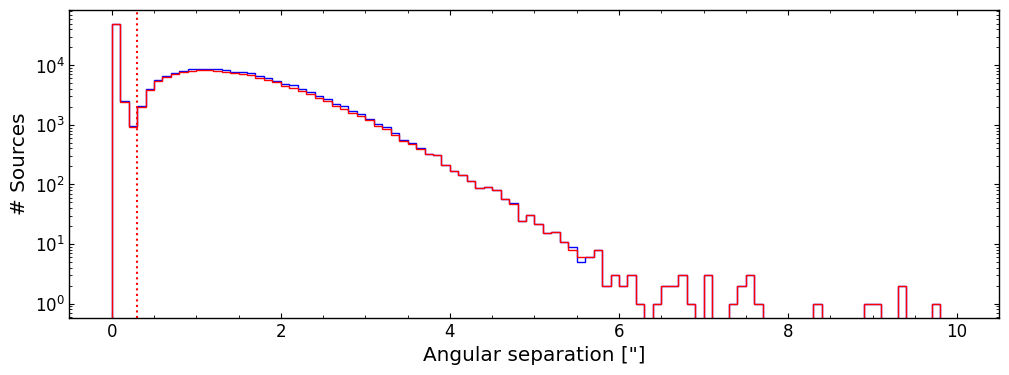

In [9]:
max_sep = 0.3*u.arcsec
phot_sersic_match = phot_sersic[d2d_sersic<max_sep]
phot_BD_match = phot_BD[d2d_BD<max_sep]
print(f"Matched sources (Sersic) : {len(phot_sersic_match)}")
print(f"Matched sources (B+D) : {len(phot_BD_match)}")

fig, ax = plt.subplots(figsize=(12,4))
ax.hist(d2d_sersic.to(u.arcsec), bins=100, range=(0*u.arcsec,10*u.arcsec), color='b', histtype='step')
ax.hist(d2d_BD.to(u.arcsec), bins=100, range=(0*u.arcsec,10*u.arcsec), color='r', histtype='step')
ax.axvline(max_sep.value, color='r', ls=':')
ax.set_yscale('log')
ax.set_xlabel('Angular separation ["]')
ax.set_ylabel('# Sources')
plt.show()

And then we match the two (Sersic and B+D) catalogs.

In [10]:
coord_sersic = SkyCoord(phot_sersic_match['world_centroid_alpha']*u.degree, phot_sersic_match['world_centroid_delta']*u.degree)
coord_BD = SkyCoord(phot_BD_match['world_centroid_alpha']*u.degree, phot_BD_match['world_centroid_delta']*u.degree)
idx, d2d, _ = coord_sersic.match_to_catalog_sky(coord_BD)
phot_sersic_match = phot_sersic_match[d2d<max_sep]
phot_BD_match = phot_BD_match[idx][d2d<max_sep]

## Clean-up

In [11]:
# Flagging : 0 = Not fitted, 1 = Potential artifcat, 2 = Good fitting, 3 = High mag or low SNR
phot_sersic_match['flag'] = 1
phot_sersic_match['flag'][(phot_sersic_match['AXRATIO']<0.99) & 
                  (np.abs(phot_sersic_match['SERSIC']-0.36)>1e-4) & 
                  (phot_sersic_match['SERSIC']<8.35)&(phot_sersic_match['SERSIC']>0.301)] = 2

phot_BD_match['flag'] = 1
phot_BD_match['flag'][(phot_BD_match['DISK_AXRATIO']<0.9999)&(phot_BD_match['DISK_AXRATIO']>0.1001) &
                      (np.abs(phot_BD_match['DISK_AXRATIO']-0.5)>1e-5)] = 2

## Add SE++ to DJA catalogs

In [12]:
coord_dja = SkyCoord(phot_dja['ra']*u.degree, phot_dja['dec']*u.degree)
coord_sersic = SkyCoord(phot_sersic_match['world_centroid_alpha']*u.degree, phot_sersic_match['world_centroid_delta']*u.degree)
coord_BD = SkyCoord(phot_BD_match['world_centroid_alpha']*u.degree, phot_BD_match['world_centroid_delta']*u.degree)
idx_sersic, d2d_sersic, _ = coord_sersic.match_to_catalog_sky(coord_dja)
idx_BD, d2d_BD, _ = coord_BD.match_to_catalog_sky(coord_dja)

In [13]:
# Columns containing lists, to be removed
list_cols_sersic = [col for col in phot_sersic_match.colnames if phot_sersic_match.dtype[col].subdtype]
list_cols_BD = [col for col in phot_BD_match.colnames if phot_BD_match.dtype[col].subdtype]

phot_sersic_match.remove_columns(list_cols_sersic)
phot_BD_match.remove_columns(list_cols_BD)

# Remove id, ra, dec from DJA photo-z table
phot_z_dja.remove_columns(['id', 'ra', 'dec'])
phot_dja.remove_columns(['z_spec'])

In [14]:
# Creating table with as many rows as the DJA table and populating them with SE++ data
tab_sersic = Table(np.full((len(phot_dja),len(phot_sersic_match.colnames)), fill_value=np.nan), names=phot_sersic_match.colnames)
tab_sersic['flag'] = 0
tab_sersic[idx_sersic] = phot_sersic_match

tab_BD = Table(np.full((len(phot_dja),len(phot_BD_match.colnames)), fill_value=np.nan), names=phot_BD_match.colnames)
tab_BD['flag'] = 0
tab_BD[idx_BD] = phot_BD_match

tab_dja = hstack([phot_dja, phot_z_dja], uniq_col_name='{table_name}_{col_name}', table_names=['DJA','DJA_z'])

In [15]:
# Masking sources with no image coverage
for filter in dja_sepp.utils.get_filter_list(tab_BD.colnames):
    no_flux = np.isnan(tab_dja[f'{filter}_flux_aper_0'])
    for col in [f'MAG_MODEL_{filter.upper()}', f'MAG_MODEL_{filter.upper()}_err', 
                f'FLUX_MODEL_{filter.upper()}', f'FLUX_MODEL_{filter.upper()}_err']:
        tab_sersic[no_flux][col] = np.nan
    for col in [f'MAG_MODEL_{filter.upper()}', f'MAG_MODEL_{filter.upper()}_err', 
                f'FLUX_MODEL_{filter.upper()}', f'FLUX_MODEL_{filter.upper()}_err',
                f'MAG_MODEL_DISK_{filter.upper()}', f'MAG_MODEL_DISK_{filter.upper()}_err', 
                f'FLUX_MODEL_DISK_{filter.upper()}', f'FLUX_MODEL_DISK_{filter.upper()}_err',
                f'MAG_MODEL_BULGE_{filter.upper()}', f'MAG_MODEL_BULGE_{filter.upper()}_err', 
                f'FLUX_MODEL_BULGE_{filter.upper()}', f'FLUX_MODEL_BULGE_{filter.upper()}_err',
                f'B/T_{filter.upper()}', f'B/T_{filter.upper()}_err', 
                f'X_B/T_{filter.upper()}', f'X_B/T_{filter.upper()}_err']:
        tab_BD[no_flux][col] = np.nan

In [ ]:
# Flagging high mag or low SNR
ZP = {'ceers-full-grizli-v7.2': 29.16,
      'gdn-grizli-v7.3': 29.93,
      'gds-grizli-v7.2': 29.93,
      'primer-uds-north-grizli-v7.2': 28.51,
      'primer-uds-south-grizli-v7.2': 28.51,
      'primer-cosmos-east-grizli-v7.0': 28.62,
      'primer-cosmos-west-grizli-v7.0': 28.62,}

low_snr = (tab_dja['flux_auto']<3*tab_dja['fluxerr_auto'])
high_mag_sersic = (tab_sersic['MAG_MODEL_F277W']>ZP[field])
high_mag_BD = (tab_BD['MAG_MODEL_F277W']>ZP[field])
tab_sersic['flag'][(tab_sersic['flag']==2) & (low_snr | high_mag_sersic)] = 3
tab_BD['flag'][(tab_BD['flag']==2) & (low_snr | high_mag_BD)] = 3

In [16]:
hdu_dja = fits.BinTableHDU(tab_dja)
hdu_sersic = fits.BinTableHDU(tab_sersic)
hdu_BD = fits.BinTableHDU(tab_BD)
hdul = fits.HDUList([fits.PrimaryHDU(), hdu_dja, hdu_sersic, hdu_BD])

In [17]:
# Save catalog
hdul.writeto(f"{home}/fields/{field}/catalog/{field}_morpho-phot.fits.gz", overwrite=True) # Compressed
hdul.writeto(f"{home}/fields/{field}/catalog/{field}_morpho-phot.fits", overwrite=True) # Un-compressed

In [18]:
# Save to S3
dja_sepp.s3.save_s3(f"{home}/fields/{field}/catalog/{field}_morpho-phot.fits.gz", 'aurelien-sepp', f"{field}/catalog")
dja_sepp.s3.save_s3(f"{home}/fields/{field}/catalog/{field}_morpho-phot.fits", 'aurelien-sepp', f"{field}/catalog")

## Completeness

In [19]:
len_dja = len(tab_dja)
len_sersic = len(tab_dja[tab_sersic['flag']!=0])
len_good_sersic = len(tab_dja[tab_sersic['flag']==2])
len_BD = len(tab_dja[tab_BD['flag']!=0])
len_good_BD = len(tab_dja[tab_BD['flag']==2])
len_sersic_BD = len(tab_dja[(tab_sersic['flag']!=0)&(tab_BD['flag']!=0)])
len_good_sersic_BD = len(tab_dja[(tab_sersic['flag']==2)&(tab_BD['flag']==2)])
print(f"{'DJA sources':<27} : {len_dja}")
print(f"{'Sérsic fitted sources':<27} : {len_sersic} ({len_sersic/len_dja*100:.1f}%)")
print(f"{'Sérsic good sources':<27} : {len_good_sersic} ({len_good_sersic/len_dja*100:.1f}%)")
print(f"{'B+D fitted sources':<27} : {len_BD} ({len_BD/len_dja*100:.1f}%)")
print(f"{'B+D good sources':<27} : {len_good_BD} ({len_good_BD/len_dja*100:.1f}%)")
print(f"{'Sérsic & B+D fitted sources':<27} : {len_sersic_BD} ({len_sersic_BD/len_dja*100:.1f}%)")
print(f"{'Sérsic & B+D good sources':<27} : {len_good_sersic_BD} ({len_good_sersic_BD/len_dja*100:.1f}%)")

DJA sources                 : 59114
Sérsic fitted sources       : 52717 (89.2%)
Sérsic good sources         : 44950 (76.0%)
B+D fitted sources          : 52716 (89.2%)
B+D good sources            : 51782 (87.6%)
Sérsic & B+D fitted sources : 52707 (89.2%)
Sérsic & B+D good sources   : 44304 (74.9%)


/tmp/ipykernel_6110/4287514765.py:16: RuntimeWarning: invalid value encountered in log10
  mag_dja = ZP - 2.5*np.log10(tab_dja[f'{filter}_tot_1']*1000)


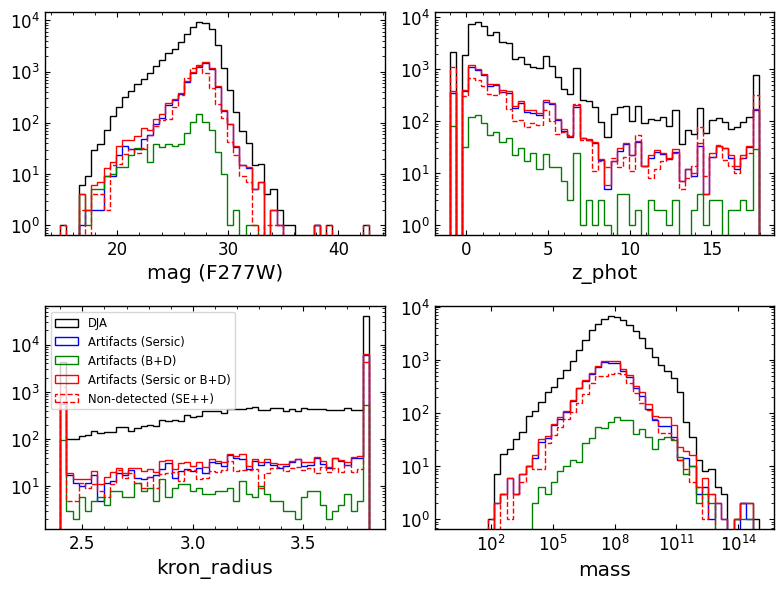

In [20]:
artifact_sersic_cond = tab_sersic['flag']==1
artifact_BD_cond = tab_BD['flag']==1
artifact_cond = artifact_sersic_cond | artifact_BD_cond

non_detect_sersic_cond = tab_sersic['flag']==0
non_detect_BD_cond = tab_BD['flag']==0
non_detect_cond = non_detect_sersic_cond | non_detect_BD_cond

log = True

fig, axs = plt.subplots(2,2,figsize=(8,6))
axs = axs.flatten()

filter = 'f277w'
ZP = (1*u.nJy).to(u.ABmag).value
mag_dja = ZP - 2.5*np.log10(tab_dja[f'{filter}_tot_1']*1000)
all = axs[0].hist(mag_dja, bins=50, histtype='step', log=log, color='k', label='DJA')
axs[0].hist(mag_dja[artifact_sersic_cond], bins=50, range=(all[1][0],all[1][-1]), histtype='step', log=log, color='b', label='Artifacts (Sersic)')
axs[0].hist(mag_dja[artifact_BD_cond], bins=50, range=(all[1][0],all[1][-1]), histtype='step', log=log, color='g', label='Artifacts (B+D)')
axs[0].hist(mag_dja[artifact_cond], bins=50, range=(all[1][0],all[1][-1]), histtype='step', log=log, color='r', label='Artifacts (Sersic or B+D)')
axs[0].hist(mag_dja[non_detect_cond], bins=50, range=(all[1][0],all[1][-1]), histtype='step', log=log, color='r', ls='--', label='Non-detected (SE++)')
axs[0].set_xlabel(f"mag ({filter.upper()})")

i, param = 1, 'z_phot'
all = axs[i].hist(tab_dja[param], bins=50, histtype='step', log=log, color='k', label='DJA')
axs[i].hist(tab_dja[artifact_sersic_cond][param], bins=50, range=(all[1][0],all[1][-1]), histtype='step', log=log, color='b', label='Artifacts (Sersic)')
axs[i].hist(tab_dja[artifact_BD_cond][param], bins=50, range=(all[1][0],all[1][-1]), histtype='step', log=log, color='g', label='Artifacts (B+D)')
axs[i].hist(tab_dja[artifact_cond][param], bins=50, range=(all[1][0],all[1][-1]), histtype='step', log=log, color='r', label='Artifacts (Sersic or B+D)')
axs[i].hist(tab_dja[non_detect_cond][param], bins=50, range=(all[1][0],all[1][-1]), histtype='step', log=log, color='r', ls='--', label='Non-detected (SE++)')
axs[i].set_xlabel(param)

i, param = 2, 'kron_radius'
all = axs[i].hist(tab_dja[param], bins=50, histtype='step', log=log, color='k', label='DJA')
axs[i].hist(tab_dja[artifact_sersic_cond][param], bins=50, range=(all[1][0],all[1][-1]), histtype='step', log=log, color='b', label='Artifacts (Sersic)')
axs[i].hist(tab_dja[artifact_BD_cond][param], bins=50, range=(all[1][0],all[1][-1]), histtype='step', log=log, color='g', label='Artifacts (B+D)')
axs[i].hist(tab_dja[artifact_cond][param], bins=50, range=(all[1][0],all[1][-1]), histtype='step', log=log, color='r', label='Artifacts (Sersic or B+D)')
axs[i].hist(tab_dja[non_detect_cond][param], bins=50, range=(all[1][0],all[1][-1]), histtype='step', log=log, color='r', ls='--', label='Non-detected (SE++)')
axs[i].set_xlabel(param)

i, param = 3, 'mass'
bins = 10**np.linspace(0,15,50)
all = axs[i].hist(tab_dja[param], bins=bins, histtype='step', log=log, color='k', label='DJA')
axs[i].hist(tab_dja[artifact_sersic_cond][param], bins=bins, range=(all[1][0],all[1][-1]), histtype='step', log=log, color='b', label='Artifacts (Sersic)')
axs[i].hist(tab_dja[artifact_BD_cond][param], bins=bins, range=(all[1][0],all[1][-1]), histtype='step', log=log, color='g', label='Artifacts (B+D)')
axs[i].hist(tab_dja[artifact_cond][param], bins=bins, range=(all[1][0],all[1][-1]), histtype='step', log=log, color='r', label='Artifacts (Sersic or B+D)')
axs[i].hist(tab_dja[non_detect_cond][param], bins=bins, range=(all[1][0],all[1][-1]), histtype='step', log=log, color='r', ls='--', label='Non-detected (SE++)')
axs[i].set_xlabel(param)
axs[i].set_xscale('log')

# axs[4].hist(tab_sersic['fmf_stop_reason'], bins=4, range=(-0.5,3.5), histtype='step', log=log, color='b', ls='--', label='All (Sersic)')
# axs[4].hist(tab_sersic[artifact_sersic_cond]['fmf_stop_reason'], bins=4, range=(-0.5,3.5), histtype='step', log=log, color='b', label='Artifacts (Sersic)')
# axs[4].set_xlabel('fmf_stop_reason')

# axs[5].hist(tab_BD['fmf_stop_reason'], bins=4, range=(-0.5,3.5), histtype='step', log=log, color='g', ls='--', label='All (B+D)')
# axs[5].hist(tab_BD[artifact_BD_cond]['fmf_stop_reason'], bins=4, range=(-0.5,3.5), histtype='step', log=log, color='g', label='Artifacts (B+D)')
# axs[5].set_xlabel('fmf_stop_reason')

axs[2].legend(fontsize='small', loc='upper left')
fig.tight_layout()
fig.savefig(f"{home}/fields/{field}/sepp/{field}_completeness.pdf", bbox_inches='tight')
fig.savefig(f"{home}/fields/{field}/sepp/{field}_completeness.png", bbox_inches='tight', dpi=200)
plt.show()

## Image

### Download full models

In [21]:
fit = 'B+D'
files = dja_sepp.s3.find_files(bucket='aurelien-sepp', 
                               path=f'{field}/sepp/{fit}/checkimages', 
                               regex=f"^(model|resid).+f\d+w.+tile-full.*\.fits")
files

[]

In [68]:
# Download files
folder = f'{home}/fields/{field}/sepp/{fit}/checkimages'
os.makedirs(folder, exist_ok=True)
for file in files:
    print(file)
    s3.download_file('aurelien-sepp', f'{field}/sepp/{fit}/checkimages/{file}', f"{folder}/{file}")

model_gds-grizli-v7.2-f090w-clear_drc_sci_tile-full_1.fits
model_gds-grizli-v7.2-f115w-clear_drc_sci_tile-full_1.fits
model_gds-grizli-v7.2-f150w-clear_drc_sci_tile-full_1.fits
model_gds-grizli-v7.2-f200w-clear_drc_sci_tile-full_1.fits
model_gds-grizli-v7.2-f277w-clear_drc_sci_tile-full_1.fits
model_gds-grizli-v7.2-f356w-clear_drc_sci_tile-full_1.fits
model_gds-grizli-v7.2-f444w-clear_drc_sci_tile-full_1.fits
resid_gds-grizli-v7.2-f090w-clear_drc_sci_tile-full_1.fits
resid_gds-grizli-v7.2-f115w-clear_drc_sci_tile-full_1.fits
resid_gds-grizli-v7.2-f150w-clear_drc_sci_tile-full_1.fits
resid_gds-grizli-v7.2-f200w-clear_drc_sci_tile-full_1.fits
resid_gds-grizli-v7.2-f277w-clear_drc_sci_tile-full_1.fits
resid_gds-grizli-v7.2-f356w-clear_drc_sci_tile-full_1.fits
resid_gds-grizli-v7.2-f444w-clear_drc_sci_tile-full_1.fits


### Lookup

In [59]:
sel = good_dja[(good_dja['z_phot']>2.0)&(good_dja['z_phot']<4.0)&
               (good_BD['B/T_F200W']>0.0)&(good_BD['B/T_F200W']<0.2)&
               (good_dja['mass']>1e10)&
               (good_sersic['snrratio']>100)&(good_sersic['MAG_MODEL_F277W']<28)]['id']
print(len(sel))

272


In [66]:
good_dja[good_dja['id']==3134]

<Table length=1>
  id         thresh         npix tnpix ... rest415_err  rest416  rest416_err
int32       float64        int64 int64 ...   float32    float32    float32  
----- -------------------- ----- ----- ... ----------- --------- -----------
 3134 0.008276831358671188  2094  1904 ...  0.01746425 1.7560399 0.048850596

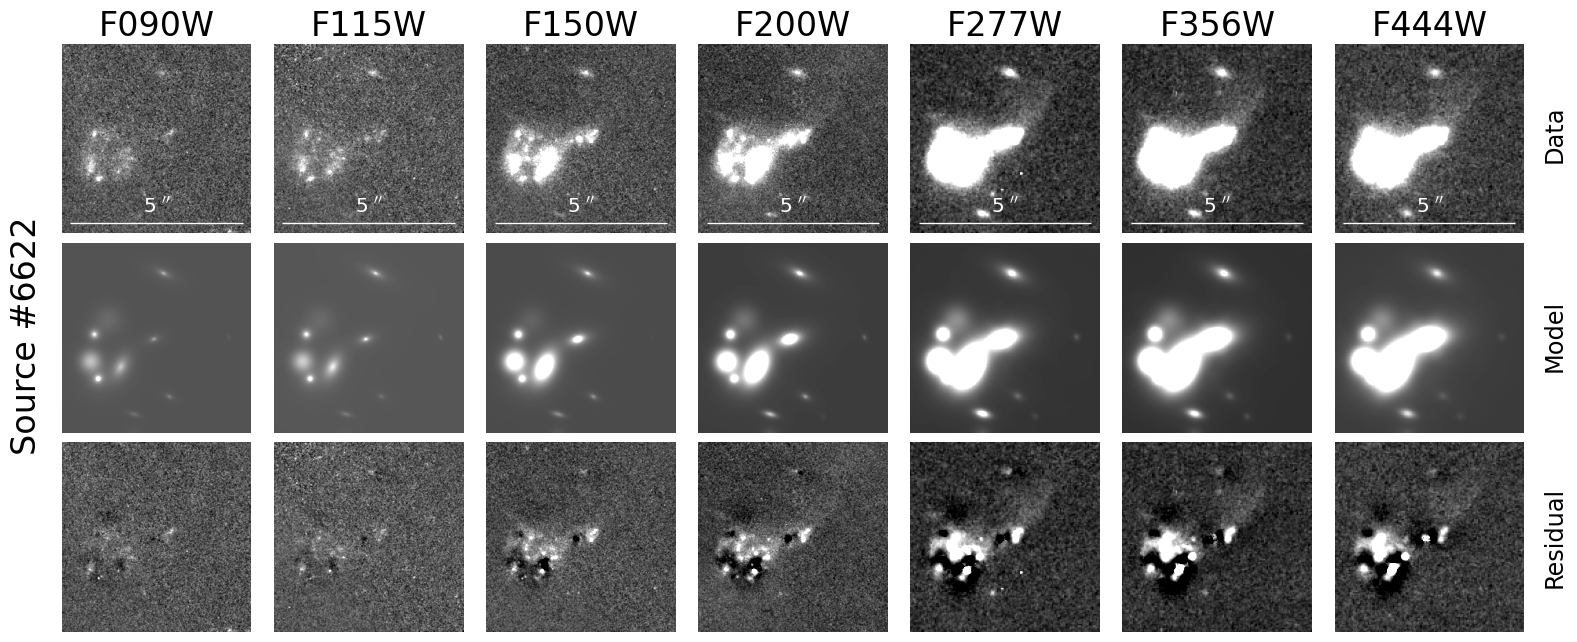

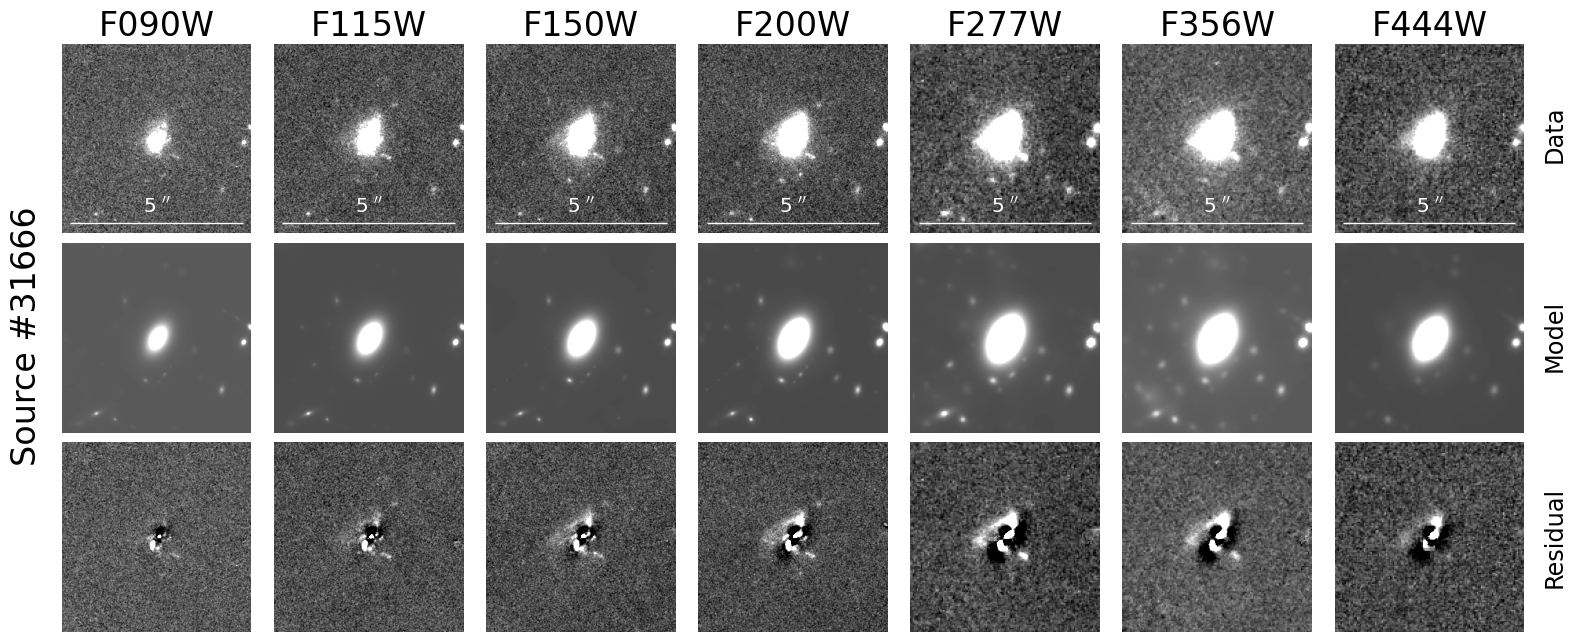

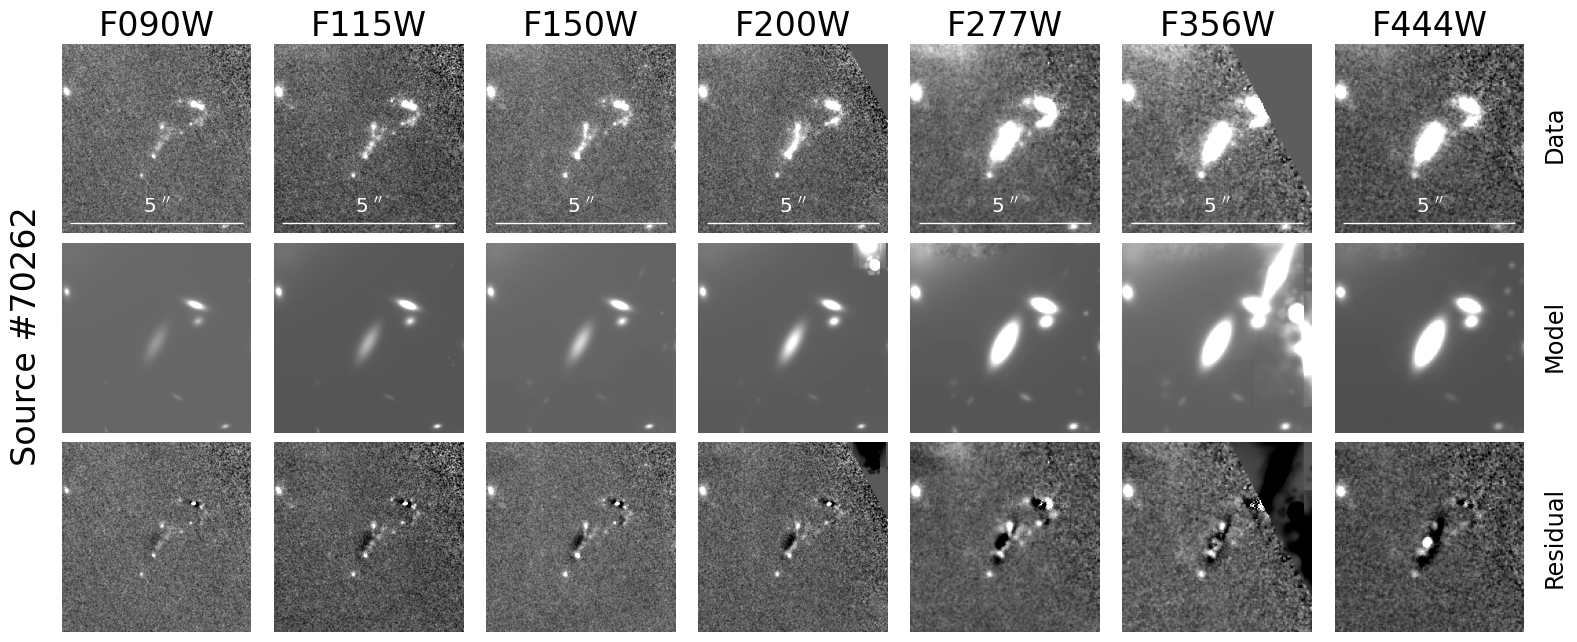

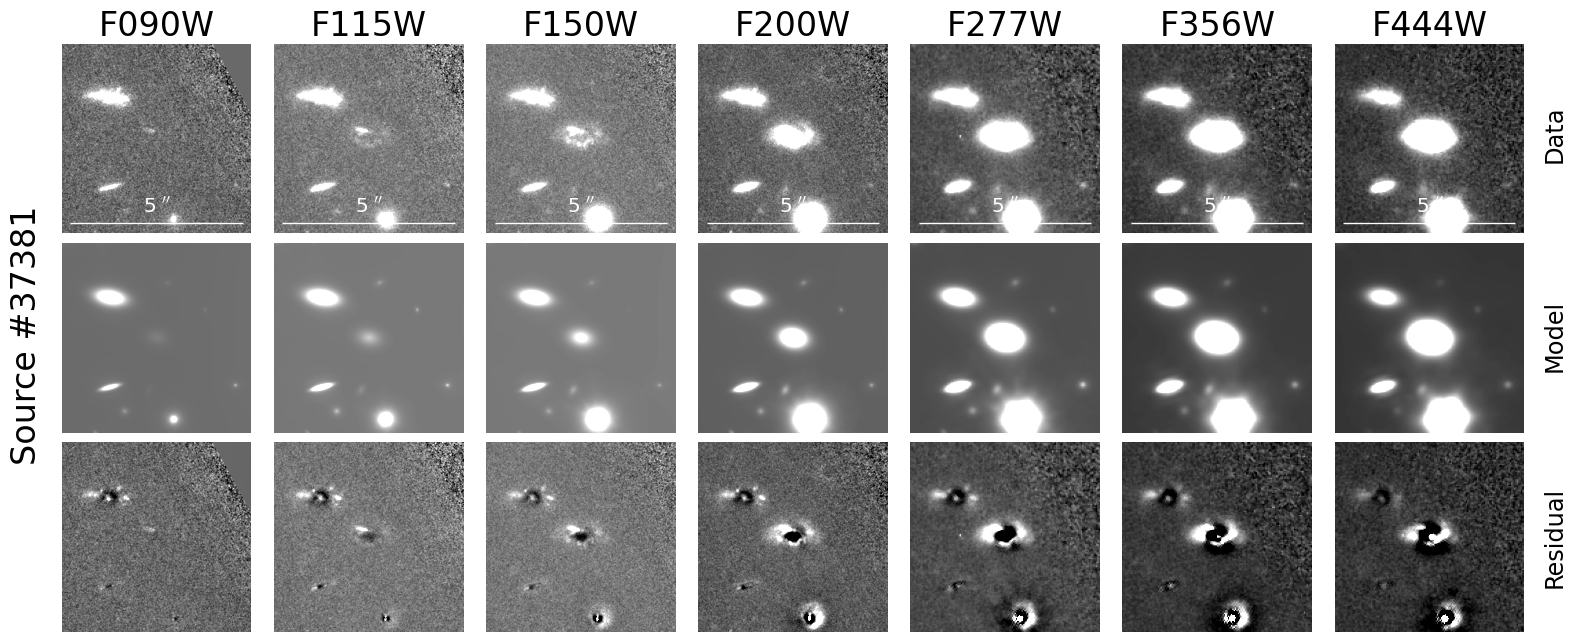

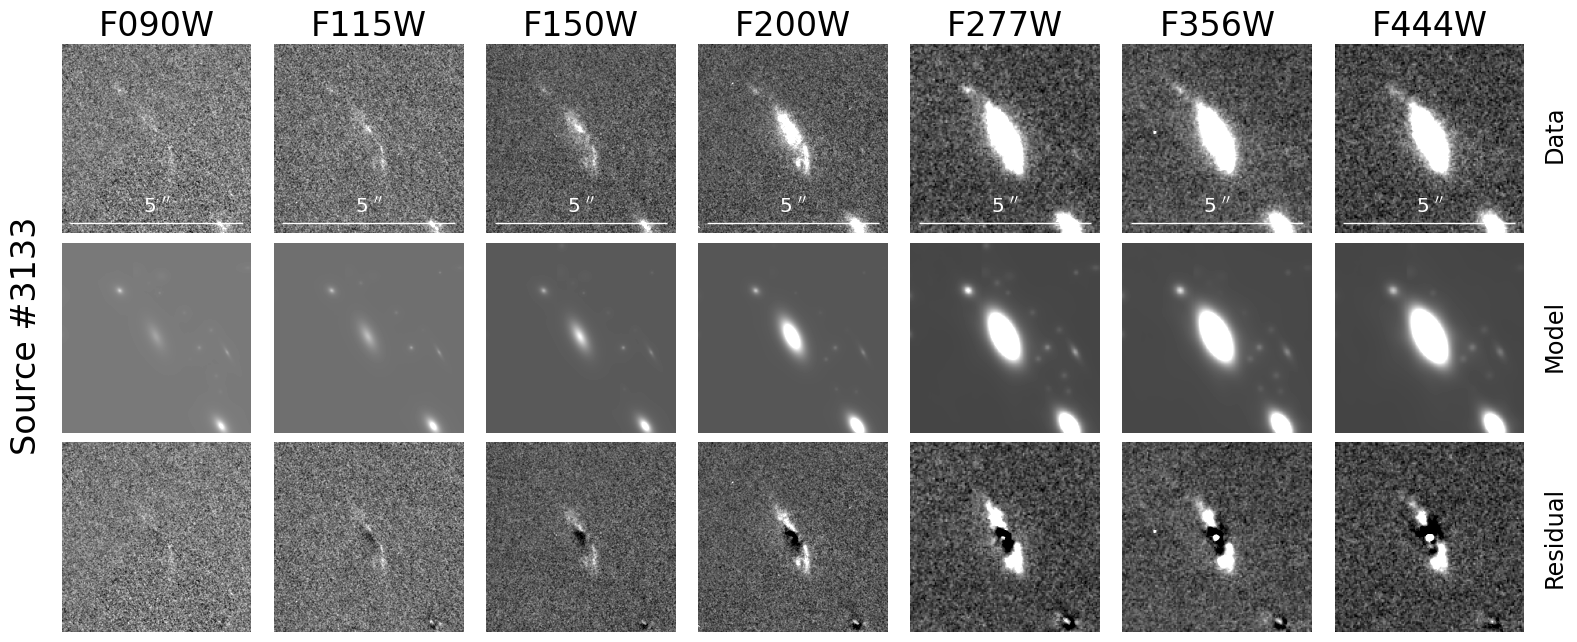

In [65]:
fit = 'sersic_rg4'
for id in np.random.choice(sel, 5):
    dja_sepp.utils.show_source(id-1, tab_BD, 
                               filter_list=['f090w', 'f115w', 'f150w', 'f200w', 'f277w', 'f356w', 'f444w'], 
                               fov=5*u.arcsec,
                               data_folder=f"{home}/fields/{field}/image",
                               model_folder=f"{home}/fields/{field}/sepp/{fit}/checkimages",
                               resid_folder=f"{home}/fields/{field}/sepp/{fit}/checkimages", 
                               data_suffix="sci.fits",
                               model_suffix="sci_tile-full_1.fits",
                               resid_suffix="sci_tile-full_1.fits")